**Rationale** This dataset includes all TripAdvisor reviews written in 2015 (through part of 2016) for high review volume Vegas resorts and was collected as part of a large web crawl of over 50 Million online reviews at over 428k worldwide hotels. 

* [Dataset](https://drive.google.com/drive/folders/1nUIOHqvOoF5EkST8u_pMcL7gvKtCy0La?usp=sharing)


### Sentiment Analysis using TextBlob

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir("drive/MyDrive/Dataset-1")

In [ ]:
df = pd.read_csv("vegas2015reviews.csv", engine="python")
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A


In [ ]:
df["mgr_res_date"], df["ratingDate"] = pd.to_datetime(df["mgr_res_date"]), pd.to_datetime(df["ratingDate"])

In [ ]:
df1 = pd.read_csv("vegas_vinfo.csv")

In [ ]:
df = df.merge(df1, "left", on="gd")

How many reviews are there?

There are 46644 reviews (Confirmed using below code)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46644 entries, 0 to 46643
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0_x     46644 non-null  int64         
 1   gd               46644 non-null  object        
 2   helpful_num      23576 non-null  float64       
 3   location         39772 non-null  object        
 4   mgrRspnDummy     46644 non-null  int64         
 5   mgr_res_date     24957 non-null  datetime64[ns]
 6   mrtext           44220 non-null  object        
 7   ratingDate       46644 non-null  datetime64[ns]
 8   review_id        46644 non-null  int64         
 9   reviewrating     46644 non-null  int64         
 10  reviewtext       46644 non-null  object        
 11  reviewtitle      46644 non-null  object        
 12  stay_month       44649 non-null  float64       
 13  stay_year        44649 non-null  float64       
 14  travel_category  44649 non-null  objec

How many unique hotels are there? Note gd is the ID variable for hotels on TripAdvisor.

34

In [ ]:
len(df["gd"].unique())

34

What are the unique types of travel categories?

Output below (Exclude the null value)

In [ ]:
df["travel_category"].unique()

array(['business', 'couple', 'friends', 'family', nan, 'solo'],
      dtype=object)

Plot a histogram of the review ratings. How would you describe the overall review ratings on TripAdvisor for Vegas resorts?

More positive reviews are observed, which indicate that there could be a bias when reviewing on TripAdvisor platform on Vegas resorts

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadeedc6c90>]],
      dtype=object)

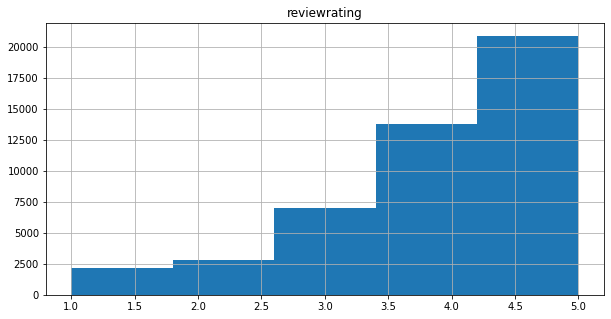

In [ ]:
df.hist(column="reviewrating", bins = 5, figsize=(10, 5))

## Sentiment

Compare the histogram of review polarity with review ratings. How are they different? What might you conclude based on this difference about how people rate and how people write?

The polarity score is like a normal distribution that peaks somewhere around 0.25 which is more of a neutral writing score rather than positive writing score. So there is definitely some difference when it comes to people writing the review and assigning the rating.

In [ ]:
df["reviewpolarity"] = df["reviewtext"].apply(lambda x: TextBlob(x).sentiment[0])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadee98d710>]],
      dtype=object)

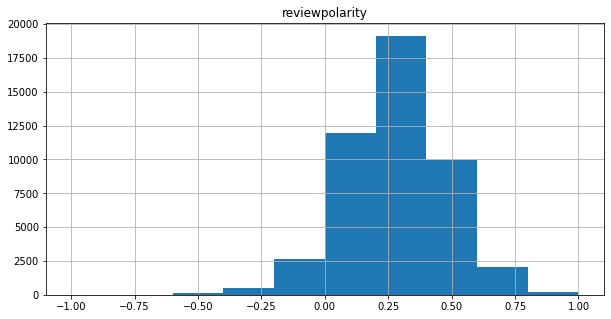

In [ ]:
df.hist(column="reviewpolarity", bins=10, figsize=(10, 5))

### Analysis between subjectivity, polarity and the user given review rating 

In [ ]:
df["reviewsubjectivity"] = df["reviewtext"].apply(lambda x: TextBlob(x).sentiment[1])

In [ ]:
df.loc[:, ["reviewsubjectivity", "reviewpolarity", "reviewrating"]].corr()


,reviewsubjectivity,reviewpolarity,reviewrating
reviewsubjectivity,1.000000,0.440563,0.237555
reviewpolarity,0.440563,1.000000,0.591409
reviewrating,0.237555,0.591409,1.000000


Most correlated category: Business

Least correlated category: Solo

First of all, the values are not very far off. The number of reviews in both of these categories are fairly low when compared to others. 

Having said that, one reason that could explain is that business category hotel goers may tend to be more professional and well educated and are primed with numbers/rating system (in the office). So they could express their opinion and rate the hotels better than the solo goers. 


In [ ]:
corr_df = df.loc[:, ["travel_category", "reviewpolarity", "reviewrating"]].groupby("travel_category").corr()

corr_df.loc[:, ["reviewrating", "reviewpolarity"]]

reviewrating  reviewpolarity
travel_category                                             
business        reviewpolarity      0.623229        1.000000
                reviewrating        1.000000        0.623229
couple          reviewpolarity      0.568238        1.000000
                reviewrating        1.000000        0.568238
family          reviewpolarity      0.599097        1.000000
                reviewrating        1.000000        0.599097
friends         reviewpolarity      0.595152        1.000000
                reviewrating        1.000000        0.595152
solo            reviewpolarity      0.536387        1.000000
                reviewrating        1.000000        0.536387

In [ ]:
df["travel_category"].value_counts()

couple      17649
friends     10380
family       8363
business     5905
solo         2352
Name: travel_category, dtype: int64

### Helper Functions

In [ ]:
import spacy, time
from gensim.models.ldamulticore import LdaMulticore 
from gensim import corpora 
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from sklearn.model_selection import train_test_split


def line_doc(filename, encode = 'utf-8'):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    with open(filename, 'r', encoding = encode) as f:
        for txt in f:
            yield txt.replace('\\n', '\n')
            

# parsing to be done per sentence
def lemmatize(s, exclude):
    return [w.lemma_.lower() for w in s if (w.lemma_ not in exclude)&(~w.is_punct)]


def lemmatize_sentence_corpus(filename,nlp, batch_size, n_threads, sw=[], exclusions=[], encode = 'utf-8'):
    nlp.disable_pipes(["ner"]) 
    exclude = set(sw + exclusions)
    for parsed_txt in nlp.pipe(line_doc(filename, encode = encode),batch_size=batch_size, n_threads=n_threads):
            for sent in parsed_txt.sents:
                yield ' '.join(lemmatize(sent, exclude))


def write_parsed_sentence_corpus(readfile, writefile, nlp, batch_size, n_threads, sw=[], exclusions =[], encode = 'utf-8'):
    streamingfile = lemmatize_sentence_corpus(readfile,nlp, batch_size, n_threads, sw=sw, exclusions=exclusions, encode = encode)
    with open(writefile, 'w', encoding = encode) as f:
        for sentence in streamingfile:
            if len(sentence)>0: # write sentence if includes non stopwords
                f.write(sentence+'\n')
    print('Success')


def phrase_detection(parsedfile, folderpath, passes = 2, returnmodels = True,threshold=10., encode = 'utf-8'):
    ngram = list()
    for it in range(passes):
        gen = LineSentence(parsedfile)
        gram=Phrases(gen, threshold = threshold)
        ngram.append(gram)
        modelpath = folderpath+'phrase_model_{}.phrasemodel'.format(it+1)
        textpath = folderpath+'sent_gram_{}.txt'.format(it+1)
        gram.save(modelpath)
        with open(textpath, 'w', encoding=encode) as f:
            for sent in gen:
                new_sent = ' '.join(gram[sent])
                f.write(new_sent + '\n')

    if returnmodels == True:
        return ngram


def phrase_prediction(rawfilepath, outpath,nlp, grams, sw =[], exclusions = [], batch_size = 500, n_threads = 2, encode = 'utf-8'):
    with open(outpath, 'w', encoding = encode) as f:
        
        nlp.disable_pipes(["ner"]) 
        exclude = set(sw + exclusions)
        
        for parsed_txt in nlp.pipe(line_doc(rawfilepath, encode = encode),batch_size=batch_size, n_threads=n_threads):
            doc = list()
            for sent in parsed_txt.sents:
                parsed = lemmatize(sent, exclude)
                for gram in grams: 
                    parsed = gram[parsed] 
                doc.append(' '.join(parsed).strip())
            
            txt_gram = ' '.join(doc).strip() 
            f.write(txt_gram + '\n') 

# Topic Modeling of the reviews using LDA and PyLDAvis 

In [ ]:
with open("raw_reviews.txt", "w") as filename:
  for row in range(df.shape[0]):
    filename.write(df.loc[row, "reviewtext"] + '\n')

In [ ]:
nlp = spacy.load("en_core_web_sm")
stopwords = list(nlp.Defaults.stop_words)
write_parsed_sentence_corpus(readfile="raw_reviews.txt", 
                             writefile="lemmatize_corpus.txt", 
                             nlp=nlp, batch_size=5, n_threads=2, sw=stopwords)

Success


In [ ]:
phrase_ngram = phrase_detection(parsedfile="lemmatize_corpus.txt", folderpath="./", 
                 passes = 2, returnmodels = True, 
                 threshold=10., encode = 'utf-8')

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
nlp = spacy.load("en_core_web_sm")
phrase_prediction(rawfilepath="raw_reviews.txt", 
                  outpath="phrased_corpus.txt", nlp=nlp, grams=phrase_ngram, sw = stopwords, 
                  batch_size = 500, n_threads = 2, encode = 'utf-8')

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
phrase_ngram

In [ ]:
parsed_list = []
with open("phrased_corpus.txt", "r") as filename:
  for row in filename:
    parsed_list.append(row)

df["parsed"] = parsed_list

In [ ]:
df.head()

,Unnamed: 0_x,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username,Unnamed: 0_y,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat,reviewpolarity,reviewsubjectivity,parsed
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaT,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.515000,0.712727,excellent property room nicely generous_size s...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaT,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.171307,0.657576,-pron- visit las_vegas wow whilst hotel strip ...
2,15046,g45963-d1123368,NaN,Brussels,0,NaT,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.253931,0.515590,beautiful hotel room world reserve wynn websit...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaT,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.334430,0.607018,hotel exceptional -pron- beautifully set spotl...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaT,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.316111,0.734931,-pron- husband -pron- stay trip vegas friend -...


In [ ]:
df.to_csv("./phrase_parsed.csv")

In [ ]:
os.listdir()

['vegas_vinfo.csv',
 'vegas2015reviews.csv',
 'raw_reviews.txt',
 'lemmatize_corpus.txt',
 'phrase_model_1.phrasemodel',
 'sent_gram_1.txt',
 'phrase_model_2.phrasemodel',
 'sent_gram_2.txt',
 'phrased_corpus.txt',
 'phrase_parsed.csv']

In [ ]:
parsed_vec = [row.split(" ") for row in parsed_list]
dc = corpora.Dictionary(parsed_vec)

In [ ]:
dc.filter_extremes()

In [ ]:
corpus = [dc.doc2bow(text) for text in parsed_vec]

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def validate_model(corpus, n_topics):
  lda_model = LdaMulticore(corpus=corpus, id2word=dc,
                                          num_topics=n_topics)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=parsed_vec, dictionary=dc,
                                       coherence='c_v')
  return (coherence_model_lda.get_coherence(), lda_model.log_perplexity(corpus))

In [ ]:
cols = ["Topics", "Coherence Val", "Perplexity Val"]
topic_out_df = pd.DataFrame(columns=cols)

for topic in range(10, 80, 10):
  #print(topic)
  (cv, pv) = validate_model(corpus, topic)
  topic_out_df = topic_out_df.append(dict(zip(cols, [topic, cv, pv])), ignore_index=True)


In [ ]:
topic_out_df

,Topics,Coherence Val,Perplexity Val
0,10.0,0.369033,-7.526474
1,20.0,0.377393,-7.624429
2,30.0,0.366926,-7.700643
3,40.0,0.353653,-7.766393
4,50.0,0.352129,-7.814999
5,60.0,0.346468,-7.861728
6,70.0,0.335843,-7.918713


In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dc,
                                          num_topics=10)

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 25.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=815a0ddbd6fd50d893949ff05ecfac06cd8ac84f83b1f1c5dafbe2c7c4dee5d0
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim_models
import pyLDAvis
import pickle

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dc)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.153755  0.039775       1        1  19.757545
8      0.132610 -0.033590       2        1  14.670876
5     -0.014636 -0.018659       3        1  13.067141
7     -0.011268 -0.044298       4        1  12.031366
2      0.056167 -0.027238       5        1   8.906943
6     -0.061564 -0.012902       6        1   8.637755
9      0.023566 -0.090943       7        1   7.775807
3      0.124643  0.127989       8        1   6.096092
4      0.023589  0.027064       9        1   5.212126
1     -0.119352  0.032802      10        1   3.844350, topic_info=           Term          Freq         Total Category  logprob  loglift
140       great  29767.000000  29767.000000  Default  30.0000  30.0000
33         good  25905.000000  25905.000000  Default  29.0000  29.0000
265        love   8321.000000   8321.000000  Default  28.0000  28.0000
833        aria  13161.000000  13161.000000  Default  27.0000  27.0000
10         nice  17559.000000  17559.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
10         nice    351.474058  17559.300013  Topic10  -5.3695  -0.6526
15      service    300.389742  13672.639704  Topic10  -5.5266  -0.5595
19        vegas    275.185765  14947.112173  Topic10  -5.6142  -0.7363
742        view    265.364639  12749.157003  Topic10  -5.6505  -0.6135
3    experience    256.304425   6729.424014  Topic10  -5.6853  -0.0093

[927 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
658        1  0.228319           
658        2  0.046352           
658        3  0.563339           
658        4  0.037173           
658        5  0.011703           
...      ...       ...        ...
7365       9  0.977590  young_hip
7450       5  0.969352        yrs
7016      10  0.962379    yrs_ago
10432      4  0.996926    zarkana
4158       2  0.970777        zoo

[3285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 6, 8, 3, 7, 10, 4, 5, 2])

In [ ]:
lda_model.print_topics()

[(0,
  '0.020*"check" + 0.011*"tell" + 0.010*"day" + 0.010*"time" + 0.010*"desk" + 0.008*"come" + 0.008*"ask" + 0.008*"night" + 0.007*"leave" + 0.006*"charge"'),
 (1,
  '0.012*"day" + 0.011*"good" + 0.010*"check" + 0.010*"bathroom" + 0.009*"use" + 0.009*"clean" + 0.007*"need" + 0.007*"shower" + 0.007*"time" + 0.006*"staff"'),
 (2,
  '0.022*"strip" + 0.021*"vegas" + 0.017*"great" + 0.016*"view" + 0.015*"casino" + 0.014*"time" + 0.013*"nice" + 0.012*"good" + 0.011*"night" + 0.011*"clean"'),
 (3,
  '0.013*"love" + 0.013*"beautiful" + 0.012*"las_vegas" + 0.012*"restaurant" + 0.012*"place" + 0.011*"amazing" + 0.011*"service" + 0.010*"vegas" + 0.010*"staff" + 0.010*"property"'),
 (4,
  '0.032*"great" + 0.017*"time" + 0.013*"suite" + 0.013*"love" + 0.012*"service" + 0.011*"view" + 0.010*"place" + 0.009*"night" + 0.009*"good" + 0.008*"like"'),
 (5,
  '0.027*"aria" + 0.016*"strip" + 0.012*"vegas" + 0.011*"good" + 0.010*"view" + 0.010*"bellagio" + 0.010*"" + 0.009*"casino" + 0.009*"walk" + 0.008

## Interpretation of the above visualization 

Topic 1 represents mainly the reviews related to the customer service

Topic 8 represents the reviews that speak about the experience of the hotel and Las Vegas in general

Topic 7 talks about the reviews related to food, restaurant and bar

In [ ]:
df.head()

,Unnamed: 0_x,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username,Unnamed: 0_y,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat,reviewpolarity,reviewsubjectivity,parsed
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaT,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.515000,0.712727,excellent property room nicely generous_size s...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaT,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.171307,0.657576,-pron- visit las_vegas wow whilst hotel strip ...
2,15046,g45963-d1123368,NaN,Brussels,0,NaT,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.253931,0.515590,beautiful hotel room world reserve wynn websit...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaT,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.334430,0.607018,hotel exceptional -pron- beautifully set spotl...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaT,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,7,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5,0.316111,0.734931,-pron- husband -pron- stay trip vegas friend -...


In [ ]:
# Considering hotel Flamingo for the last task
# Satisfied Customers: Review Polarity >= 0 and vice versa for Dissatisfied customers
df_flamingo_pos = df[(df["v_name"] == "Flamingo Las Vegas Hotel & Casino") & (df["reviewpolarity"] >= 0)].copy()
df_flamingo_neg = df[(df["v_name"] == "Flamingo Las Vegas Hotel & Casino") & (df["reviewpolarity"] < 0)].copy()


In [ ]:
def topic_analyzer(parsed_list):
  parsed_vec = [row.split(" ") for row in parsed_list]
  corpus_pos = [dc.doc2bow(text) for text in parsed_vec]
  LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_pos, dc)
  return LDAvis_prepared

In [ ]:
# Satisfied customers
parsed_list = df_flamingo_pos["reviewtext"]
topic_analyzer(parsed_list)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.124643 -0.127989       1        1  24.630826
0     -0.153755 -0.039775       2        1  18.604242
1     -0.119352 -0.032802       3        1  17.587787
8      0.132610  0.033590       4        1   7.708838
7     -0.011268  0.044298       5        1   6.776164
5     -0.014636  0.018659       6        1   6.614127
6     -0.061564  0.012902       7        1   6.508465
4      0.023589 -0.027064       8        1   5.529009
9      0.023566  0.090943       9        1   3.757569
2      0.056167  0.027238      10        1   2.282974, topic_info=          Term         Freq        Total Category  logprob  loglift
140      great  1211.000000  1211.000000  Default  30.0000  30.0000
33        good  1146.000000  1146.000000  Default  29.0000  29.0000
48       strip   690.000000   690.000000  Default  28.0000  28.0000
10        nice   797.000000   797.000000  Default  27.0000  27.0000
131     casino   781.000000   781.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
20       visit    15.700833   493.011441  Topic10  -5.1104   0.3329
134        day    16.858726   704.173985  Topic10  -5.0393   0.0475
634      large    11.629861   308.062604  Topic10  -5.4106   0.5030
316      place    12.261048   715.191521  Topic10  -5.3577  -0.2864
63   beautiful    11.723195   505.683045  Topic10  -5.4026   0.0154

[918 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
658        1  0.254153         
658        2  0.254153         
658        3  0.047065         
658        4  0.028239         
658        5  0.023533         
...      ...       ...      ...
254       10  0.016298     year
5729       4  1.036861    yes\n
7016       3  1.008073  yrs_ago
10432      5  0.990825  zarkana
4158       4  1.201797      zoo

[2557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 9, 8, 6, 7, 5, 10, 3])

In [ ]:
# Dissatisfied customers
parsed_list = df_flamingo_neg["reviewtext"]
topic_analyzer(parsed_list)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.153755  0.039775       1        1  30.015213
3      0.124643  0.127989       2        1  20.326439
1     -0.119352  0.032802       3        1  17.745221
6     -0.061564 -0.012902       4        1   9.434819
7     -0.011268 -0.044298       5        1   6.008304
4      0.023589  0.027064       6        1   4.580382
5     -0.014636 -0.018659       7        1   4.277911
9      0.023566 -0.090943       8        1   3.072901
8      0.132610 -0.033590       9        1   2.860098
2      0.056167 -0.027238      10        1   1.678710, topic_info=            Term        Freq       Total Category  logprob  loglift
140        great  178.000000  178.000000  Default  30.0000  30.0000
33          good  189.000000  189.000000  Default  29.0000  29.0000
10          nice  158.000000  158.000000  Default  28.0000  28.0000
131       casino  137.000000  137.000000  Default  27.0000  27.0000
48         strip  113.000000  113.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
134          day    2.643781  171.936461  Topic10  -5.0393  -0.0878
436  comfortable    1.794625   45.940691  Topic10  -5.4267   0.8446
634        large    1.823792   60.420337  Topic10  -5.4106   0.5867
316        place    1.922774  128.324110  Topic10  -5.3577  -0.1136
63     beautiful    1.838428   88.586721  Topic10  -5.4026   0.2121

[901 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
658        1  0.433677         
658        2  0.228251         
658        3  0.045650         
658        5  0.022825         
658        6  0.022825         
...      ...       ...      ...
254        7  0.013077     year
254        8  0.039231     year
254        9  0.013077     year
254       10  0.013077     year
10432      5  0.982200  zarkana

[1756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 7, 8, 5, 6, 10, 9, 3])

#### For the hotel Flamingo, the satisfied customers talk a lot about the place and the experience with the place and casino in their reviews whereas the dissatisfied customers talk a lot about the customer service topic